/var/folders/kq/m5dcsnyx0hv_6c9ydgm10nhw0000gn/T/ipykernel_88504/4207973712.py:228: UserWarning: The figure layout has changed to tight
  self.fig1.tight_layout()
/var/folders/kq/m5dcsnyx0hv_6c9ydgm10nhw0000gn/T/ipykernel_88504/4207973712.py:229: UserWarning: The figure layout has changed to tight
  self.fig2.tight_layout()
2025-05-21 18:12:54.138 python[88504:6101326] +[IMKClient subclass]: chose IMKClient_Modern
2025-05-21 18:12:54.138 python[88504:6101326] +[IMKInputSession subclass]: chose IMKInputSession_Modern
2025-05-21 18:12:58.829 python[88504:6101326] The class 'NSOpenPanel' overrides the method identifier.  This method is implemented by class 'NSWindow'


Dataset1 Download Successfully


/var/folders/kq/m5dcsnyx0hv_6c9ydgm10nhw0000gn/T/ipykernel_88504/4207973712.py:318: UserWarning: The figure layout has changed to tight
  self.fig1.tight_layout()


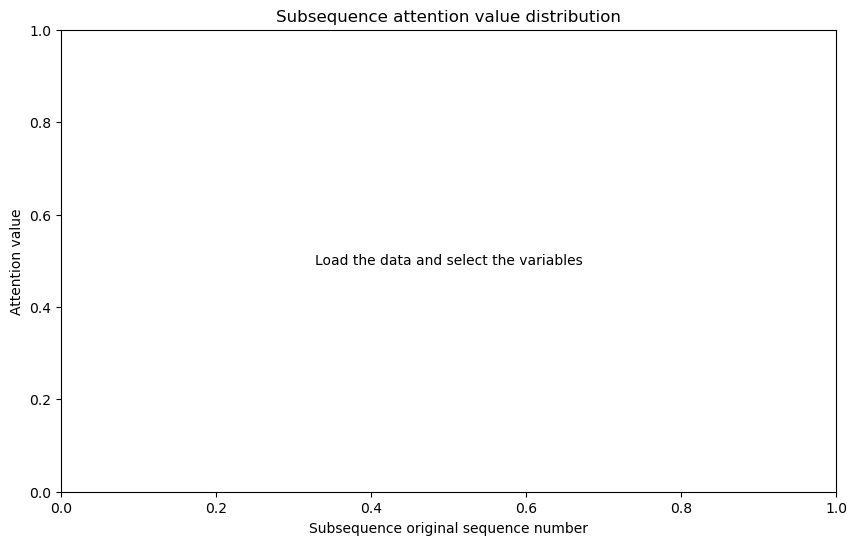

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tkinter as tk
from tkinter import ttk, filedialog, messagebox
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg, NavigationToolbar2Tk
from matplotlib.figure import Figure
import torch
import torch.nn as nn
import torch.nn.functional as F
import os

class IntegratedVisualizer:
    def __init__(self, root):
        self.root = root
        self.root.title("Time Series Visualization Integration Tool")
        self.root.geometry("1200x800")
        
        self.notebook = ttk.Notebook(root)
        self.notebook.pack(fill=tk.BOTH, expand=True)
        
        self.tab1 = ttk.Frame(self.notebook)
        self.tab2 = ttk.Frame(self.notebook)
        self.tab3 = ttk.Frame(self.notebook)
        
        self.notebook.add(self.tab1, text="Multi-image Display Tool")
        self.notebook.add(self.tab2, text="Cross Attention Visualization")
        self.notebook.add(self.tab3, text="Attention Value Distribution")
        
        self.initialize_tab1()
        self.initialize_tab2()
        self.initialize_tab3()
    
    def initialize_tab1(self):
        self.visualizer1 = CombinedVisualizer(self.tab1)
    
    def initialize_tab2(self):
        self.visualizer2 = AttentionVisualizer(self.tab2)
    
    def initialize_tab3(self):
        self.visualizer3 = TimeSeriesVisualizerApp(self.tab3)

# ====== The First Function ======
class CombinedVisualizer:
    def __init__(self, root):
        self.root = root
        
        self.data1 = None
        self.labels1 = None
        self.colors1 = None
        self.data2 = None
        self.var_info = None
        
        self.color_map = {
            1: 'red',
            2: 'blue',
            3: 'green',
            4: 'yellow',
            5: 'purple',
            6: 'cyan'
        }
        
        self.sequence_ranges = {
            (0, 150): 1,    
            (150, 300): 2,  
            (300, 450): 3, 
            (450, 600): 4,  
            (600, 750): 5,  
            (750, 900): 6  
        }
        
        self.create_frames()
        self.create_controls()
        self.create_plots()
        self.update_sample_selectors()
    
    def get_color_for_subsequence(self, subsequence_idx):
        for (start, end), color_code in self.sequence_ranges.items():
            if start <= subsequence_idx < end:
                return self.color_map[color_code]
        return 'black'  
    
    def get_dimension_for_subsequence(self, subsequence_idx):
        dimension_ranges = {
            (0, 149): 1,    
            (150, 299): 2,  
            (300, 449): 3,  
            (450, 599): 4,  
            (600, 749): 5,  
            (750, 899): 6   
        }
        for (start, end), dimension in dimension_ranges.items():
            if start <= subsequence_idx <= end:
                return dimension
        return 0  
    
    def create_frames(self):
        self.left_frame = ttk.Frame(self.root, padding="10")
        self.left_frame.grid(row=0, column=0, sticky=(tk.N, tk.W, tk.E, tk.S))
        
        self.right_frame = ttk.Frame(self.root, padding="10")
        self.right_frame.grid(row=0, column=2, sticky=(tk.N, tk.W, tk.E, tk.S))
        
        self.root.columnconfigure(0, weight=1)
        self.root.columnconfigure(2, weight=3)  
        self.root.rowconfigure(0, weight=1)
        
        self.right_frame.rowconfigure(0, weight=2)  
        self.right_frame.rowconfigure(2, weight=2) 
        self.right_frame.columnconfigure(0, weight=1)
    
    def create_controls(self):
        self.create_left_controls()

    def create_left_controls(self):
        ttk.Label(self.left_frame, text="Multi-image Display Control Panel", font=('Arial', 10, 'bold')).grid(row=0, column=0, columnspan=4, pady=10)
        ttk.Button(self.left_frame, text="Download Data File", command=self.load_data1).grid(row=1, column=0, columnspan=4, pady=5)
    
        ttk.Label(self.left_frame, text="Choose the Number of Plots:").grid(row=2, column=0, columnspan=4, pady=5)
        self.num_plots = ttk.Spinbox(self.left_frame, from_=1, to=4, width=10, command=self.update_sample_selectors)
        self.num_plots.set(1)
        self.num_plots.grid(row=3, column=0, columnspan=4, pady=5)
    
        self.create_selectors()
    
        ttk.Button(self.left_frame, text="Update Multi-image Display", command=self.update_plots1).grid(row=10, column=0, columnspan=4, pady=20)

        ttk.Label(self.left_frame, text="Dual-image Display Control Panel", font=('Arial', 10, 'bold')).grid(row=11, column=1, columnspan=2, pady=10)
    
        ttk.Label(self.left_frame, text="Choose Dataset:").grid(row=12, column=1, columnspan=2, pady=5)
        self.dataset_selector = ttk.Combobox(self.left_frame, values=["Basic Motions Data"])
        self.dataset_selector.grid(row=13, column=1, columnspan=2, pady=5)
        ttk.Button(self.left_frame, text="Load Dataset", command=self.load_data2).grid(row=14, column=1, columnspan=2, pady=5)
    
        ttk.Label(self.left_frame, text="Choose Variable1:").grid(row=15, column=0, columnspan=2, pady=5)
        self.sample_selector1 = ttk.Spinbox(self.left_frame, from_=1, to=40, width=10)
        self.sample_selector1.set(1)
        self.sample_selector1.grid(row=16, column=0, columnspan=2, pady=5)
        
        ttk.Label(self.left_frame, text="Choose Variable2:").grid(row=15, column=2, columnspan=2, pady=5)
        self.sample_selector2 = ttk.Spinbox(self.left_frame, from_=1, to=40, width=10)
        self.sample_selector2.set(1)
        self.sample_selector2.grid(row=16, column=2, columnspan=2, pady=5)
     
        ttk.Label(self.left_frame, text="Choose Subsequence1:").grid(row=17, column=0, columnspan=2, pady=5)
        self.subsequence_selector1 = ttk.Spinbox(self.left_frame, from_=1, to=900, width=10)
        self.subsequence_selector1.set(1)
        self.subsequence_selector1.grid(row=18, column=0, columnspan=2, pady=5)

        ttk.Label(self.left_frame, text="Choose Subsequence2:").grid(row=17, column=2, columnspan=2, pady=5)
        self.subsequence_selector2 = ttk.Spinbox(self.left_frame, from_=1, to=900, width=10)
        self.subsequence_selector2.set(1)
        self.subsequence_selector2.grid(row=18, column=2, columnspan=2, pady=5)
        
        ttk.Button(self.left_frame, text="Update Dual Image Display", command=self.update_plot2).grid(row=19, column=1, columnspan=2, pady=20)
        
        # Add a separator
        ttk.Separator(self.left_frame, orient='horizontal').grid(row=20, column=0, columnspan=4, pady=10, sticky='ew')
        
        # Add new button for viewing subsequence in original sequence
        ttk.Button(self.left_frame, text="Show the Position of Subsequence in Original", 
                  command=self.show_subsequence_in_original).grid(row=21, column=1, columnspan=2, pady=10)
    
    def create_selectors(self):
        # Subsequence=(Variable-1)6+Dimension
        ttk.Label(self.left_frame, text="Variable:").grid(row=4, column=0, columnspan=4, pady=5)
        self.sample_selectors = []
        self.time_selectors = []
        self.length_selectors = []
        
        for i in range(4):
            frame = ttk.Frame(self.left_frame)
            frame.grid(row=5, column=i, padx=3)
            ttk.Label(frame, text=f"p{i+1}:").pack()
            selector = ttk.Spinbox(frame, from_=1, to=240, width=5)
            selector.set(i+1)
            selector.pack()
            self.sample_selectors.append(selector)

            frame = ttk.Frame(self.left_frame)
            frame.grid(row=7, column=i, padx=3)
            ttk.Label(frame, text=f"p{i+1}:").pack()
            time_sel = ttk.Spinbox(frame, from_=0, to=99, width=5)
            time_sel.set(0)
            time_sel.pack()
            self.time_selectors.append(time_sel)

            frame = ttk.Frame(self.left_frame)
            frame.grid(row=9, column=i, padx=3)
            ttk.Label(frame, text=f"p{i+1}:").pack()
            length_sel = ttk.Spinbox(frame, from_=1, to=100, width=5)
            length_sel.set(100)
            length_sel.pack()
            self.length_selectors.append(length_sel)
        
        ttk.Label(self.left_frame, text="time0:").grid(row=6, column=0, columnspan=4, pady=2)
        ttk.Label(self.left_frame, text="length:").grid(row=8, column=0, columnspan=4, pady=2)
    
    def create_plots(self):
        self.fig1 = Figure(figsize=(8, 5))
        self.fig2 = Figure(figsize=(8, 5)) 

        self.canvas1 = FigureCanvasTkAgg(self.fig1, master=self.right_frame)
        self.canvas1_widget = self.canvas1.get_tk_widget()
        self.canvas1_widget.grid(row=0, column=0, sticky=(tk.N, tk.W, tk.E, tk.S))
        
        self.canvas2 = FigureCanvasTkAgg(self.fig2, master=self.right_frame)
        self.canvas2_widget = self.canvas2.get_tk_widget()
        self.canvas2_widget.grid(row=2, column=0, sticky=(tk.N, tk.W, tk.E, tk.S))

        self.toolbar_frame1 = ttk.Frame(self.right_frame)
        self.toolbar_frame1.grid(row=1, column=0, sticky='ew')
        self.toolbar1 = NavigationToolbar2Tk(self.canvas1, self.toolbar_frame1)
        
        self.toolbar_frame2 = ttk.Frame(self.right_frame)
        self.toolbar_frame2.grid(row=3, column=0, sticky='ew')
        self.toolbar2 = NavigationToolbar2Tk(self.canvas2, self.toolbar_frame2)

        self.root.bind("<Configure>", self.on_window_resize)
        
    def on_window_resize(self, event):
        if event.widget != self.root:
            return

        if hasattr(self, 'canvas1') and hasattr(self, 'canvas2'):
            self.adjust_plot_layout()
            
    def adjust_plot_layout(self):
        self.fig1.tight_layout()
        self.fig2.tight_layout()

        self.fig1.subplots_adjust(top=0.95, bottom=0.1, left=0.1, right=0.95)
        self.fig2.subplots_adjust(hspace=0.3, top=0.95, bottom=0.1, left=0.1, right=0.95)

        self.canvas1.draw()
        self.canvas2.draw()

        self.canvas1_widget.update_idletasks()
        self.canvas2_widget.update_idletasks()
    
    def update_sample_selectors(self):
        n_plots = int(self.num_plots.get())
        for i, (sample_sel, time_sel, length_sel) in enumerate(zip(self.sample_selectors, 
                                                                  self.time_selectors, 
                                                                  self.length_selectors)):
            state = 'normal' if i < n_plots else 'disabled'
            sample_sel.configure(state=state)
            time_sel.configure(state=state)
            length_sel.configure(state=state)
    
    def load_data1(self):
        file_path = filedialog.askopenfilename(filetypes=[("NPY files", "*.npy")])
        if file_path:
            try:
                combined_data = np.load(file_path)
                self.data1 = combined_data[:, :, 0]  
                self.labels1 = combined_data[:, 0, 1]  
                self.colors1 = combined_data[:, 0, 2]  
                print("Dataset1 Download Successfully")
                self.update_plots1()
            except Exception as e:
                print(f"Download File Error: {str(e)}")
    
    def load_data2(self):
        dataset_paths = {
            "Basic Motions Data": "BasicMotions_train.npz"}
        
        selected_dataset = self.dataset_selector.get()
        if selected_dataset in dataset_paths:
            file_path = dataset_paths[selected_dataset]
            try:
                npz_data = np.load(file_path)
                self.data2 = npz_data['arr_0']
                self.var_info = npz_data['arr_1']
                print("Dataset2 Download Successfully")
                self.update_plot2()
            except Exception as e:
                print(f"Download File Error: {str(e)}")

    def update_plots1(self):
        if self.data1 is None or self.labels1 is None:
            print("Please download dataset1 at first")
            return
            
        self.fig1.clear()
        n_plots = int(self.num_plots.get())
        
        self.fig1.subplots_adjust(hspace=0.4)
        
        axes = []
        for i in range(n_plots):
            ax = self.fig1.add_subplot(n_plots, 1, i+1)
            axes.append(ax)
            
            sample_idx = int(self.sample_selectors[i].get()) - 1
            start_time = int(self.time_selectors[i].get())
            seq_len = int(self.length_selectors[i].get())
            
            end_time = min(start_time + seq_len, self.data1.shape[1])
            time_points = range(start_time, end_time)

            color_code = int(self.colors1[sample_idx])
            color = self.color_map.get(color_code, 'black')  

            ax.plot(time_points, 
                   self.data1[sample_idx, start_time:end_time], 
                   color=color,
                   label=f'Dimension {(sample_idx % 6) + 1}')

            dimension = (sample_idx % 6) + 1
            ax.set_title(f'Sample {sample_idx+1} - Dimension {dimension} - Label: {self.labels1[sample_idx]}')
            ax.legend()
            ax.grid(True)

            ax.set_ylabel(f'Value (Dim {dimension})')

        axes[-1].set_xlabel('Time Points')
        
        self.fig1.tight_layout()
        self.canvas1.draw()
    
    def update_plot2(self):
        if self.data2 is None or self.var_info is None:
            print("Please download dataset2")
            return
        
        self.fig2.clear()
    
        sample_idx1 = int(self.sample_selector1.get()) - 1
        subsequence_idx1 = int(self.subsequence_selector1.get()) - 1

        sample_idx2 = int(self.sample_selector2.get()) - 1
        subsequence_idx2 = int(self.subsequence_selector2.get()) - 1

        ax1 = self.fig2.add_subplot(2, 1, 1)
        ax2 = self.fig2.add_subplot(2, 1, 2)

        color1 = self.get_color_for_subsequence(subsequence_idx1)
        dimension1 = self.get_dimension_for_subsequence(subsequence_idx1)
    
        start_time1 = int(self.var_info[sample_idx1, subsequence_idx1, 1])
        end_time1 = int(self.var_info[sample_idx1, subsequence_idx1, 2])
    
        try:
            original_idx1 = (sample_idx1) * 6 + dimension1 - 1

            time_points_full1 = np.arange(len(self.data1[original_idx1]))
            ax1.plot(time_points_full1, self.data1[original_idx1], 
                   color='gray', 
                   linewidth=1,
                   label='Original Sequence')

            ax1.plot(time_points_full1[start_time1:end_time1+1], 
                   self.data1[original_idx1, start_time1:end_time1+1],
                   color='red',
                   linewidth=2,
                   label='Selected Subsequence')
   
            time_points1 = np.arange(start_time1, end_time1 + 1)
            data_points1 = self.data2[sample_idx1, subsequence_idx1, :len(time_points1)]
            ax1.scatter(time_points1, data_points1, 
                      color=color1, marker='o', s=30,
                      label=f'Subsequence Data (Dim {dimension1})')
            
        except Exception as e:
            print(f"Unable to highlight subsequence 1: {str(e)}")
            time_points1 = np.arange(start_time1, end_time1 + 1)
            data_points1 = self.data2[sample_idx1, subsequence_idx1, :len(time_points1)]
            ax1.plot(time_points1, data_points1,
                    color=color1,
                    label=f'Subsequence {subsequence_idx1+1} (Dim {dimension1})')
    
        range_info1 = ""
        for (start, end), color_code in self.sequence_ranges.items():
            if start <= subsequence_idx1 < end:
                range_info1 = f" (Range: {start+1}-{end})"
                break
    
        var_info_text1 = f"VP info: {self.var_info[sample_idx1, subsequence_idx1, :]}"
        ax1.text(0.95, 0.95, var_info_text1, 
                horizontalalignment='right', 
                verticalalignment='top', 
                transform=ax1.transAxes,
                bbox=dict(facecolor='white', alpha=0.5),
                fontsize=9)
    
        ax1.set_title(f'Variable {sample_idx1+1} - Subsequence {subsequence_idx1+1}{range_info1} - Dimension {dimension1}', fontsize=10)
        ax1.legend(fontsize=9)
        ax1.grid(True)
        ax1.set_ylabel('Value', fontsize=9)

        color2 = self.get_color_for_subsequence(subsequence_idx2)
        dimension2 = self.get_dimension_for_subsequence(subsequence_idx2)
    
        start_time2 = int(self.var_info[sample_idx2, subsequence_idx2, 1])
        end_time2 = int(self.var_info[sample_idx2, subsequence_idx2, 2])
        
        try:
            original_idx2 = (sample_idx2) * 6 + dimension2 - 1

            time_points_full2 = np.arange(len(self.data1[original_idx2]))
            ax2.plot(time_points_full2, self.data1[original_idx2], 
                   color='gray', 
                   linewidth=1,
                   label='Original Sequence')
     
            ax2.plot(time_points_full2[start_time2:end_time2+1], 
                   self.data1[original_idx2, start_time2:end_time2+1],
                   color='blue', 
                   linewidth=2,
                   label='Selected Subsequence')
     
            time_points2 = np.arange(start_time2, end_time2 + 1)
            data_points2 = self.data2[sample_idx2, subsequence_idx2, :len(time_points2)]
            ax2.scatter(time_points2, data_points2, 
                      color=color2, marker='o', s=30,
                      label=f'Subsequence Data (Dim {dimension2})')
            
        except Exception as e:
            print(f"Unable to highlight subsequence 2: {str(e)}")
            time_points2 = np.arange(start_time2, end_time2 + 1)
            data_points2 = self.data2[sample_idx2, subsequence_idx2, :len(time_points2)]
            ax2.plot(time_points2, data_points2,
                    color=color2,
                    label=f'Subsequence {subsequence_idx2+1} (Dim {dimension2})')
    
        range_info2 = ""
        for (start, end), color_code in self.sequence_ranges.items():
            if start <= subsequence_idx2 < end:
                range_info2 = f" (Range: {start+1}-{end})"
                break
    
        var_info_text2 = f"VP info: {self.var_info[sample_idx2, subsequence_idx2, :]}"
        ax2.text(0.95, 0.95, var_info_text2, 
                horizontalalignment='right', 
                verticalalignment='top', 
                transform=ax2.transAxes,
                bbox=dict(facecolor='white', alpha=0.5),
                fontsize=9)
    
        ax2.set_title(f'Variable {sample_idx2+1} - Subsequence {subsequence_idx2+1}{range_info2} - Dimension {dimension2}', fontsize=10)
        ax2.legend(fontsize=9)
        ax2.grid(True)
        ax2.set_xlabel('Time Points', fontsize=9)
        ax2.set_ylabel('Value', fontsize=9)
    
        self.adjust_plot_layout()

    def show_subsequence_in_original(self):
        if self.data1 is None or self.data2 is None or self.var_info is None:
            print("Please make sure both data files are loaded")
            return
            
        try:
            self.fig2.clear()
            
            ax1 = self.fig2.add_subplot(2, 1, 1)
            ax2 = self.fig2.add_subplot(2, 1, 2)
            
            variable1 = int(self.sample_selector1.get())
            subsequence_idx1 = int(self.subsequence_selector1.get()) - 1
            
            dimension1 = self.get_dimension_for_subsequence(subsequence_idx1)
            original_idx1 = (variable1 - 1) * 6 + dimension1 - 1
            
            start_time1 = int(self.var_info[variable1-1, subsequence_idx1, 1])
            end_time1 = int(self.var_info[variable1-1, subsequence_idx1, 2])
            
            time_points1 = np.arange(len(self.data1[original_idx1]))
            ax1.plot(time_points1, self.data1[original_idx1], 
                   color='gray', 
                   linewidth=1,
                   label='Original Sequence')
            
            ax1.plot(time_points1[start_time1:end_time1+1], 
                   self.data1[original_idx1, start_time1:end_time1+1],
                   color='red',
                   linewidth=2,
                   label='Selected Subsequence')
            
            ax1.set_title(f'Variable {variable1} - Original Sequence (Dimension {dimension1})\n' +
                        f'Subsequence {subsequence_idx1+1} highlighted (Time: {start_time1}-{end_time1})', 
                        fontsize=10)
            ax1.legend(fontsize=9)
            ax1.grid(True)
            ax1.set_ylabel('Value', fontsize=9)
            
            variable2 = int(self.sample_selector2.get())
            subsequence_idx2 = int(self.subsequence_selector2.get()) - 1
            
            dimension2 = self.get_dimension_for_subsequence(subsequence_idx2)
            original_idx2 = (variable2 - 1) * 6 + dimension2 - 1
            
            start_time2 = int(self.var_info[variable2-1, subsequence_idx2, 1])
            end_time2 = int(self.var_info[variable2-1, subsequence_idx2, 2])
            
            time_points2 = np.arange(len(self.data1[original_idx2]))
            ax2.plot(time_points2, self.data1[original_idx2], 
                   color='gray', 
                   linewidth=1,
                   label='Original Sequence')
            
            ax2.plot(time_points2[start_time2:end_time2+1], 
                   self.data1[original_idx2, start_time2:end_time2+1],
                   color='blue', 
                   linewidth=2,
                   label='Selected Subsequence')
            
            ax2.set_title(f'Variable {variable2} - Original Sequence (Dimension {dimension2})\n' +
                        f'Subsequence {subsequence_idx2+1} highlighted (Time: {start_time2}-{end_time2})', 
                        fontsize=10)
            ax2.legend(fontsize=9)
            ax2.grid(True)
            ax2.set_xlabel('Time Points', fontsize=9)
            ax2.set_ylabel('Value', fontsize=9)
            
            self.adjust_plot_layout()
            
        except Exception as e:
            print(f"Error displaying subsequence position: {str(e)}")

# ====== Second function: Cross-attention visualization ======
class CrossAttention(nn.Module):
    def __init__(self, seq_length):
        super(CrossAttention, self).__init__()
        self.query = nn.Linear(seq_length, seq_length)
        self.key = nn.Linear(seq_length, seq_length)
        self.value = nn.Linear(seq_length, seq_length)
        self.softmax = nn.Softmax(dim=-1)
    
    def forward(self, Q, K):
        # Query, Key, Value
        Q = self.query(Q)
        K = self.key(K)
        V = self.value(K)
        
        # Calculate attention weights
        scores = torch.matmul(Q, K.T) / torch.sqrt(torch.tensor(Q.shape[-1], dtype=torch.float32))
        attention_weights = self.softmax(scores)
        
        return attention_weights

class AttentionVisualizer:
    def __init__(self, root):
        self.root = root
        
        # Dataset paths - Update these paths to your actual dataset locations
        self.datasets = {
            "Dataset": "BasicMotions_train.npz"
        }
        
        self.npy_files = []  # For the new npy files
        self.npy_data = None  # To store the loaded NPY data
        
        self.current_data = None
        self.attention_model = None
        self.seq_length = 30
        self.colorbar = None  # Track the colorbar
        
        # Add these lines after initializing other variables
        self.current_x_range = (0, 899)  # Default range (0-indexed)
        self.current_y_range = (0, 899)  # Default range (0-indexed)
        
        # Create main frame layout
        self.main_frame = ttk.PanedWindow(root, orient=tk.HORIZONTAL)
        self.main_frame.pack(fill=tk.BOTH, expand=True)
        
        # Left panel for controls
        self.left_panel = ttk.Frame(self.main_frame, width=300)
        self.main_frame.add(self.left_panel, weight=1)
        
        # Right panel for visualization
        self.right_panel = ttk.Frame(self.main_frame)
        self.main_frame.add(self.right_panel, weight=3)
        
        # Divide right panel into top and bottom sections
        self.right_top = ttk.Frame(self.right_panel)
        self.right_top.pack(fill=tk.BOTH, expand=True)
        
        self.right_bottom = ttk.Frame(self.right_panel)
        self.right_bottom.pack(fill=tk.BOTH, expand=True)
        
        # Setup controls
        self.setup_controls()
        
        # Setup figure for attention visualization (top)
        self.fig_attention = plt.Figure(figsize=(8, 4))
        self.ax_attention = self.fig_attention.add_subplot(111)
        self.canvas_attention = FigureCanvasTkAgg(self.fig_attention, master=self.right_top)
        self.canvas_attention.get_tk_widget().pack(fill=tk.BOTH, expand=True)
        
        # Setup figures for sequence visualization (bottom)
        self.fig_sequences = plt.Figure(figsize=(8, 4))
        self.ax_seq1 = self.fig_sequences.add_subplot(211)
        self.ax_seq2 = self.fig_sequences.add_subplot(212)
        self.canvas_sequences = FigureCanvasTkAgg(self.fig_sequences, master=self.right_bottom)
        self.canvas_sequences.get_tk_widget().pack(fill=tk.BOTH, expand=True)
        
    def setup_controls(self):
        # Dataset selection
        ttk.Label(self.left_panel, text="Dataset Selection", font=("Arial", 12, "bold")).pack(anchor="w", pady=(10, 5))
        self.dataset_var = tk.StringVar(value=list(self.datasets.keys())[0])
        self.dataset_combo = ttk.Combobox(self.left_panel, textvariable=self.dataset_var, values=list(self.datasets.keys()), state="readonly")
        self.dataset_combo.pack(fill=tk.X, pady=5)
        self.dataset_combo.bind("<<ComboboxSelected>>", self.load_dataset)
        
        # Variable selection
        ttk.Label(self.left_panel, text="Variable Selection", font=("Arial", 12, "bold")).pack(anchor="w", pady=(15, 5))
        variable_frame = ttk.Frame(self.left_panel)
        variable_frame.pack(fill=tk.X, pady=5)
        
        # X-axis variable
        ttk.Label(variable_frame, text="X-axis Variable:").grid(row=0, column=0, sticky="w", pady=5)
        self.x_var = tk.IntVar(value=1)
        self.x_var_spinbox = ttk.Spinbox(variable_frame, from_=1, to=40, textvariable=self.x_var, width=5)
        self.x_var_spinbox.grid(row=0, column=1, sticky="w", padx=5)
        
        # Y-axis variable
        ttk.Label(variable_frame, text="Y-axis Variable:").grid(row=1, column=0, sticky="w", pady=5)
        self.y_var = tk.IntVar(value=6)
        self.y_var_spinbox = ttk.Spinbox(variable_frame, from_=1, to=40, textvariable=self.y_var, width=5)
        self.y_var_spinbox.grid(row=1, column=1, sticky="w", padx=5)
        
        # Range selection for X and Y axes
        ttk.Label(self.left_panel, text="Sequence Range Selection", font=("Arial", 12, "bold")).pack(anchor="w", pady=(15, 5))
        
        # X-axis range
        ttk.Label(self.left_panel, text="X-axis Range:").pack(anchor="w", pady=(5, 0))
        x_range_frame = ttk.Frame(self.left_panel)
        x_range_frame.pack(fill=tk.X, pady=(0, 5))
        
        ttk.Label(x_range_frame, text="From:").grid(row=0, column=0, sticky="w")
        self.x_min = tk.IntVar(value=1)
        self.x_min_spinbox = ttk.Spinbox(x_range_frame, from_=1, to=900, textvariable=self.x_min, width=5)
        self.x_min_spinbox.grid(row=0, column=1, sticky="w", padx=5)
        
        ttk.Label(x_range_frame, text="To:").grid(row=0, column=2, sticky="w")
        self.x_max = tk.IntVar(value=900)
        self.x_max_spinbox = ttk.Spinbox(x_range_frame, from_=1, to=900, textvariable=self.x_max, width=5)
        self.x_max_spinbox.grid(row=0, column=3, sticky="w", padx=5)
        
        # Y-axis range
        ttk.Label(self.left_panel, text="Y-axis Range:").pack(anchor="w", pady=(5, 0))
        y_range_frame = ttk.Frame(self.left_panel)
        y_range_frame.pack(fill=tk.X, pady=(0, 5))
        
        ttk.Label(y_range_frame, text="From:").grid(row=0, column=0, sticky="w")
        self.y_min = tk.IntVar(value=1)
        self.y_min_spinbox = ttk.Spinbox(y_range_frame, from_=1, to=900, textvariable=self.y_min, width=5)
        self.y_min_spinbox.grid(row=0, column=1, sticky="w", padx=5)
        
        ttk.Label(y_range_frame, text="To:").grid(row=0, column=2, sticky="w")
        self.y_max = tk.IntVar(value=900)
        self.y_max_spinbox = ttk.Spinbox(y_range_frame, from_=1, to=900, textvariable=self.y_max, width=5)
        self.y_max_spinbox.grid(row=0, column=3, sticky="w", padx=5)
        
        # Add a separator
        ttk.Separator(self.left_panel, orient='horizontal').pack(fill='x', pady=10)
        
        # NPY File Selection section
        ttk.Label(self.left_panel, text="File Selection", font=("Arial", 12, "bold")).pack(anchor="w", pady=(10, 5))#npy NPY File Selection
        
        # Button to load NPY files
        self.load_npy_btn = ttk.Button(self.left_panel, text="Load Files", command=self.load_npy_files)# Load NPY Files
        self.load_npy_btn.pack(fill=tk.X, pady=5)
        
        # NPY file selection
        ttk.Label(self.left_panel, text="Select File:").pack(anchor="w", pady=(5, 0))# Select NPY File
        self.npy_file_var = tk.StringVar()
        self.npy_file_combo = ttk.Combobox(self.left_panel, textvariable=self.npy_file_var, state="readonly")
        self.npy_file_combo.pack(fill=tk.X, pady=5)
        self.npy_file_combo.bind("<<ComboboxSelected>>", self.on_npy_file_selected)
        
        # Sequence number selection (two values between 1-900)
        ttk.Label(self.left_panel, text="Sequence Selection:", font=("Arial", 11, "bold")).pack(anchor="w", pady=(10, 5))
        
        # First sequence selection
        ttk.Label(self.left_panel, text="First Sequence Number (1-900):").pack(anchor="w", pady=(5, 0))
        self.seq1_var = tk.IntVar(value=8)
        self.seq1_spinbox = ttk.Spinbox(self.left_panel, from_=1, to=900, textvariable=self.seq1_var, width=10)
        self.seq1_spinbox.pack(fill=tk.X, pady=5)
        
        # Display dimension for first sequence
        self.seq1_dim_var = tk.StringVar(value=f"Dimension: {self.get_dimension(8)}")
        ttk.Label(self.left_panel, textvariable=self.seq1_dim_var).pack(anchor="w")
        
        # Second sequence selection
        ttk.Label(self.left_panel, text="Second Sequence Number (1-900):").pack(anchor="w", pady=(10, 0))
        self.seq2_var = tk.IntVar(value=38)
        self.seq2_spinbox = ttk.Spinbox(self.left_panel, from_=1, to=900, textvariable=self.seq2_var, width=10)
        self.seq2_spinbox.pack(fill=tk.X, pady=5)
        
        # Display dimension for second sequence
        self.seq2_dim_var = tk.StringVar(value=f"Dimension: {self.get_dimension(38)}")
        ttk.Label(self.left_panel, textvariable=self.seq2_dim_var).pack(anchor="w")
        
        # Add trace to update dimension labels when sequence numbers change
        self.seq1_var.trace_add("write", self.update_dimension_labels)
        self.seq2_var.trace_add("write", self.update_dimension_labels)
        
        # Update button
        self.update_btn = ttk.Button(self.left_panel, text="Update Visualization", command=self.update_visualization)
        self.update_btn.pack(fill=tk.X, pady=20)
        
    def get_dimension(self, value):
        # Determine dimension based on the value range
        if 1 <= value <= 150:
            return 1
        elif 151 <= value <= 300:
            return 2
        elif 301 <= value <= 450:
            return 3
        elif 451 <= value <= 600:
            return 4
        elif 601 <= value <= 750:
            return 5
        elif 751 <= value <= 900:
            return 6
        else:
            return 1  # Default to 1 if out of range
            
    def load_npy_files(self):
        # Open file dialog to select multiple NPY files
        files = filedialog.askopenfilenames(
            title="Select NPY Files",
            filetypes=[("NPY Files", "*.npy"), ("NPZ Files", "*.npz"), ("All Files", "*.*")]
        )
        
        if files:
            self.npy_files = list(files)
            # Update the combobox with file names only (not full paths)
            file_names = [os.path.basename(f) for f in self.npy_files]
            self.npy_file_combo['values'] = file_names
            if file_names:
                self.npy_file_var.set(file_names[0])
                self.on_npy_file_selected()
    
    def on_npy_file_selected(self, event=None):
        if not self.npy_file_var.get():
            return
        
        try:
            # Get selected NPY file path
            file_idx = self.npy_file_combo['values'].index(self.npy_file_var.get())
            npy_file_path = self.npy_files[file_idx]
            
            # Load NPY file
            self.npy_data = np.load(npy_file_path, allow_pickle=True)
            print(f"Loaded NPY file with keys: {self.npy_data.files if hasattr(self.npy_data, 'files') else 'No keys (not an NPZ file)'}")
            
            # Update sequence visualization
            self.update_sequence_visualization()
        except Exception as e:
            import traceback
            traceback.print_exc()
            messagebox.showerror("Error", f"Failed to load NPY file: {e}")
    
    def load_dataset(self, event=None):
        dataset_name = self.dataset_var.get()
        dataset_path = self.datasets[dataset_name]
        
        try:
            self.current_data = np.load(dataset_path)
            self.attention_model = CrossAttention(self.seq_length)
            self.update_visualization()
        except Exception as e:
            messagebox.showerror("Error", f"Failed to load dataset: {e}")
    
    def update_visualization(self):
        if self.current_data is None:
            messagebox.showerror("Error", "Please load a dataset first")
            return
        
        try:
            # Get selected variables
            x_var_idx = self.x_var.get() - 1  # Convert from 1-indexed to 0-indexed
            y_var_idx = self.y_var.get() - 1
            
            # Get selected ranges (convert from 1-indexed to 0-indexed)
            x_min = self.x_min.get() - 1
            x_max = self.x_max.get() - 1
            y_min = self.y_min.get() - 1
            y_max = self.y_max.get() - 1
            
            # Validate range inputs
            if x_min < 0 or y_min < 0 or x_max >= 900 or y_max >= 900 or x_min > x_max or y_min > y_max:
                messagebox.showerror("Error", "Invalid range selection. Range should be between 1-900 and min ≤ max.")
                return
            
            # Extract data
            arr_0 = self.current_data['arr_0']  # Shape: (40, 900, 30)
            
            if x_var_idx >= arr_0.shape[0] or y_var_idx >= arr_0.shape[0]:
                messagebox.showerror("Error", f"Variable index out of range. Dataset has {arr_0.shape[0]} variables.")
                return
            
            variable_x = arr_0[x_var_idx]  # Shape: (900, 30)
            variable_y = arr_0[y_var_idx]  # Shape: (900, 30)
            
            # Convert to PyTorch tensors
            variable_x_tensor = torch.tensor(variable_x, dtype=torch.float32)
            variable_y_tensor = torch.tensor(variable_y, dtype=torch.float32)
            
            # Calculate attention weights
            with torch.no_grad():
                attention_weights = self.attention_model(variable_x_tensor, variable_y_tensor)
            
            # Convert to numpy for visualization
            attention_weights_np = attention_weights.detach().numpy()
            
            # Extract the requested subset of the attention matrix
            subset_attention = attention_weights_np[y_min:y_max+1, x_min:x_max+1]
            
            # Clear the attention figure and recreate the axis
            self.fig_attention.clear()
            self.ax_attention = self.fig_attention.add_subplot(111)
            
            # Create the heatmap
            im = self.ax_attention.imshow(subset_attention, cmap="viridis", aspect='auto')
            
            # Add a new colorbar
            self.colorbar = self.fig_attention.colorbar(im, ax=self.ax_attention)
            
            # Set labels and title
            self.ax_attention.set_title(f"Attention Weights Between Variable {x_var_idx+1} and Variable {y_var_idx+1}")
            self.ax_attention.set_xlabel(f"Variable {x_var_idx+1} Sequence Position ({x_min+1}-{x_max+1})")
            self.ax_attention.set_ylabel(f"Variable {y_var_idx+1} Sequence Position ({y_min+1}-{y_max+1})")
            
            # Set tick labels (limit the number to avoid overcrowding)
            x_ticks = np.linspace(0, x_max-x_min, min(10, x_max-x_min+1), dtype=int)
            x_tick_labels = x_min + 1 + x_ticks
            y_ticks = np.linspace(0, y_max-y_min, min(10, y_max-y_min+1), dtype=int)
            y_tick_labels = y_min + 1 + y_ticks
            
            self.ax_attention.set_xticks(x_ticks)
            self.ax_attention.set_xticklabels(x_tick_labels)
            self.ax_attention.set_yticks(y_ticks)
            self.ax_attention.set_yticklabels(y_tick_labels)
            
            # Store the range information for click event handling
            self.current_x_range = (x_min, x_max)
            self.current_y_range = (y_min, y_max)
            
            # Add click event handler to the heatmap
            self.fig_attention.canvas.mpl_connect('button_press_event', self.on_heatmap_click)
            
            self.fig_attention.tight_layout()
            self.canvas_attention.draw()
            
            # Update sequence visualization if NPY file is selected
            self.update_sequence_visualization()
            
        except Exception as e:
            import traceback
            traceback.print_exc()
            messagebox.showerror("Error", f"Failed to update visualization: {e}")
    
    def on_heatmap_click(self, event):
        """Handle click events on the heatmap."""
        if event.inaxes != self.ax_attention:
            return
        
        try:
            # Get the clicked position
            x_click, y_click = int(round(event.xdata)), int(round(event.ydata))
            
            # Convert to actual sequence numbers based on the current range
            x_min, x_max = self.current_x_range
            y_min, y_max = self.current_y_range
            
            x_seq_num = x_min + 1 + x_click  # +1 because sequence numbers are 1-indexed
            y_seq_num = y_min + 1 + y_click  # +1 because sequence numbers are 1-indexed
            
            # Get the selected variables
            x_var_idx = self.x_var.get() - 1
            y_var_idx = self.y_var.get() - 1
            
            print(f"Clicked on position: ({x_click}, {y_click})")
            print(f"Corresponding to sequence numbers: ({x_seq_num}, {y_seq_num})")
            print(f"For variables: ({x_var_idx+1}, {y_var_idx+1})")
            
            # Update the sequence number spinboxes
            self.seq1_var.set(x_seq_num)
            self.seq2_var.set(y_seq_num)
            
            # Update the visualization with the new sequence numbers
            self.update_sequence_visualization()
            
        except Exception as e:
            import traceback
            traceback.print_exc()
            print(f"Error handling click event: {e}")
    
    def update_sequence_visualization(self):
        # Check if NPY data is loaded
        if self.npy_data is None:
            return
        
        try:
            # Get selected sequence numbers
            seq1_num = self.seq1_var.get()
            seq2_num = self.seq2_var.get()
            
            # Determine dimensions based on sequence numbers
            dim1 = self.get_dimension(seq1_num)
            dim2 = self.get_dimension(seq2_num)
            
            # Get selected variables
            x_var_idx = self.x_var.get() - 1  # Convert from 1-indexed to 0-indexed
            y_var_idx = self.y_var.get() - 1  # Convert from 1-indexed to 0-indexed
            
            # Calculate sequence indices based on the formula: 6*(variable-1)+Dimension
            # Since variable is already 0-indexed after the subtraction above, we use 6*variable+dim
            seq1_idx = 6 * x_var_idx + dim1 - 1  # Subtract 1 because dimensions are 1-indexed
            seq2_idx = 6 * y_var_idx + dim2 - 1  # Subtract 1 because dimensions are 1-indexed
            
            print(f"Sequence 1 index: {seq1_idx}, Sequence 2 index: {seq2_idx}")
            print(f"Sequence 1 number: {seq1_num}, Sequence 2 number: {seq2_num}")
            
            # Check if it's an NPZ file with arr_0 and arr_1
            if not isinstance(self.npy_data, np.ndarray) and 'arr_0' in self.npy_data and 'arr_1' in self.npy_data:
                # Extract sequences from arr_0
                arr_0 = self.npy_data['arr_0']
                arr_1 = self.npy_data['arr_1']
                
                print(f"arr_0 shape: {arr_0.shape}, arr_1 shape: {arr_1.shape}")
                
                if seq1_idx < arr_0.shape[0] and seq2_idx < arr_0.shape[0]:
                    seq1_data = arr_0[seq1_idx]
                    seq2_data = arr_0[seq2_idx]
                    
                    # Get Variable-Position information from arr_1
                    # Important: We need to use the x_var_idx and y_var_idx to get the VP info
                    # for the selected variables, and then use seq1_num and seq2_num to get the 
                    # specific VP info for those sequence numbers
                    
                    # For first sequence (using x_var_idx and seq1_num)
                    if x_var_idx < arr_1.shape[0] and seq1_num-1 < arr_1.shape[1]:
                        seq1_vp = arr_1[x_var_idx, seq1_num-1]
                        print(f"Sequence 1 VP info for var {x_var_idx+1}, seq {seq1_num}: {seq1_vp}")
                    else:
                        print(f"Invalid indices for seq1 VP: var_idx={x_var_idx}, seq_num={seq1_num-1}")
                        seq1_vp = np.array([0, 0, 0, 0])
                    
                    # For second sequence (using y_var_idx and seq2_num)
                    if y_var_idx < arr_1.shape[0] and seq2_num-1 < arr_1.shape[1]:
                        seq2_vp = arr_1[y_var_idx, seq2_num-1]
                        print(f"Sequence 2 VP info for var {y_var_idx+1}, seq {seq2_num}: {seq2_vp}")
                    else:
                        print(f"Invalid indices for seq2 VP: var_idx={y_var_idx}, seq_num={seq2_num-1}")
                        seq2_vp = np.array([0, 0, 0, 0])
                    
                    # Store VP info for highlighting
                    vp_info_seq1 = [seq1_vp]
                    vp_info_seq2 = [seq2_vp]
                else:
                    messagebox.showerror("Error", f"Calculated sequence indices out of range. Max index: {arr_0.shape[0]-1}")
                    return
            else:
                # Handle regular NPY files or different structure
                if isinstance(self.npy_data, np.ndarray):
                    # Assume it's a single array
                    if self.npy_data.ndim >= 3 and seq1_idx < self.npy_data.shape[0] and seq2_idx < self.npy_data.shape[0]:
                        seq1_data = self.npy_data[seq1_idx]
                        seq2_data = self.npy_data[seq2_idx]
                    else:
                        messagebox.showerror("Error", "NPY data does not have the expected dimensions")
                        return
                else:
                    messagebox.showerror("Error", "NPY data does not have the expected structure")
                    return
                
                # No VP info available for regular NPY files
                # No VP info available for regular NPY files
                vp_info_seq1 = []
                vp_info_seq2 = []
            
            # Clear the sequence figure
            self.fig_sequences.clear()
            self.ax_seq1 = self.fig_sequences.add_subplot(211)
            self.ax_seq2 = self.fig_sequences.add_subplot(212)
            
            # Plot the first sequence
            time_points = np.arange(len(seq1_data))
            if seq1_data.ndim > 1:
                # Plot all dimensions with thin lines
                for dim in range(seq1_data.shape[1]):
                    if dim == 0:  # Make the first dimension line thicker
                        self.ax_seq1.plot(time_points, seq1_data[:, dim], 'b-', linewidth=2, label=f'Dim {dim+1}')
                    else:
                        self.ax_seq1.plot(time_points, seq1_data[:, dim], 'b-', alpha=0.3, linewidth=0.5)
            else:
                self.ax_seq1.plot(time_points, seq1_data, 'b-', linewidth=2)
            
            # Highlight regions based on VP info for sequence 1
            if len(vp_info_seq1) > 0:
                for i, vp in enumerate(vp_info_seq1):
                    # VP format: (original_idx, start, end, label)
                    if isinstance(vp, np.ndarray) and vp.size >= 3:
                        start, end = int(vp[1]), int(vp[2])
                        print(f"Highlighting seq1 region: {start}-{end}")
                        if start >= 0 and end > start:  # Valid range
                            # Use a more visible highlighting with higher z-order to ensure it's visible
                            self.ax_seq1.axvspan(start, end, alpha=0.3, color='red', zorder=5)
                            
                            # Add a label for the highlighted region
                            y_range = self.ax_seq1.get_ylim()
                            y_pos = y_range[0] + 0.9 * (y_range[1] - y_range[0])
                            self.ax_seq1.text((start + end) / 2, y_pos, 
                                             f"VP: {start}-{end}", horizontalalignment='center',
                                             bbox=dict(facecolor='white', alpha=0.7, edgecolor='red'),
                                             zorder=6)
                            
                            # Add vertical lines at start and end points for better visibility
                            self.ax_seq1.axvline(x=start, color='red', linestyle='--', alpha=0.7, zorder=4)
                            self.ax_seq1.axvline(x=end, color='red', linestyle='--', alpha=0.7, zorder=4)
            
            # Plot the second sequence
            if seq2_data.ndim > 1:
                # Plot all dimensions with thin lines
                for dim in range(seq2_data.shape[1]):
                    if dim == 0:  # Make the first dimension line thicker
                        self.ax_seq2.plot(time_points, seq2_data[:, dim], 'g-', linewidth=2, label=f'Dim {dim+1}')
                    else:
                        self.ax_seq2.plot(time_points, seq2_data[:, dim], 'g-', alpha=0.3, linewidth=0.5)
            else:
                self.ax_seq2.plot(time_points, seq2_data, 'g-', linewidth=2)
            
            # Highlight regions based on VP info for sequence 2
            if len(vp_info_seq2) > 0:
                for i, vp in enumerate(vp_info_seq2):
                    # VP format: (original_idx, start, end, label)
                    if isinstance(vp, np.ndarray) and vp.size >= 3:
                        start, end = int(vp[1]), int(vp[2])
                        print(f"Highlighting seq2 region: {start}-{end}")
                        if start >= 0 and end > start:  # Valid range
                            # Use a more visible highlighting with higher z-order to ensure it's visible
                            self.ax_seq2.axvspan(start, end, alpha=0.3, color='red', zorder=5)
                            
                            # Add a label for the highlighted region
                            y_range = self.ax_seq2.get_ylim()
                            y_pos = y_range[0] + 0.9 * (y_range[1] - y_range[0])
                            self.ax_seq2.text((start + end) / 2, y_pos, 
                                             f"VP: {start}-{end}", horizontalalignment='center',
                                             bbox=dict(facecolor='white', alpha=0.7, edgecolor='red'),
                                             zorder=6)
                            
                            # Add vertical lines at start and end points for better visibility
                            self.ax_seq2.axvline(x=start, color='red', linestyle='--', alpha=0.7, zorder=4)
                            self.ax_seq2.axvline(x=end, color='red', linestyle='--', alpha=0.7, zorder=4)
            
            # Set titles and labels with more detailed information
            self.ax_seq1.set_title(f"Variable {x_var_idx+1}, Sequence #{seq1_num} (Dim: {dim1}, Index: {seq1_idx})")
            self.ax_seq2.set_title(f"Variable {y_var_idx+1}, Sequence #{seq2_num} (Dim: {dim2}, Index: {seq2_idx})")
            
            self.ax_seq1.set_ylabel("Value")
            self.ax_seq2.set_xlabel("Time Point")
            self.ax_seq2.set_ylabel("Value")
            
            # Add grid for better visibility
            self.ax_seq1.grid(True, linestyle='--', alpha=0.6)
            self.ax_seq2.grid(True, linestyle='--', alpha=0.6)
            
            # Add legend if multiple dimensions are plotted
            if seq1_data.ndim > 1 and seq1_data.shape[1] > 1:
                self.ax_seq1.legend(loc='upper right')
            if seq2_data.ndim > 1 and seq2_data.shape[1] > 1:
                self.ax_seq2.legend(loc='upper right')
            
            self.fig_sequences.tight_layout()
            self.canvas_sequences.draw()
            
        except Exception as e:
            import traceback
            traceback.print_exc()
            messagebox.showerror("Error", f"Failed to update sequence visualization: {e}")
    
    def update_dimension_labels(self, *args):
        # Update dimension labels based on current sequence values
        seq1 = self.seq1_var.get()
        seq2 = self.seq2_var.get()
        
        dim1 = self.get_dimension(seq1)
        dim2 = self.get_dimension(seq2)
        
        self.seq1_dim_var.set(f"Dimension: {dim1}")
        self.seq2_dim_var.set(f"Dimension: {dim2}")

# ====== The third function: visualization of attention value distribution ======
class TimeSeriesVisualizerApp:
    def __init__(self, root):
        self.root = root
    
        self.data = None
        self.selected_variable = tk.StringVar()
        self.num_subsequences = tk.StringVar()
        self.num_subsequences.set("100")  
        
        left_frame = ttk.Frame(root, padding=10)
        left_frame.pack(side=tk.LEFT, fill=tk.Y)
        
        ttk.Label(left_frame, text="1. Dataset loading", font=('Arial', 12, 'bold')).pack(anchor=tk.W, pady=(0, 5))
        ttk.Button(left_frame, text="download BasicMotions_train.npz", command=self.load_data).pack(fill=tk.X, pady=(0, 20))
        
        ttk.Label(left_frame, text="2. choose Variable (1-40)", font=('Arial', 12, 'bold')).pack(anchor=tk.W, pady=(0, 5))
        variable_combobox = ttk.Combobox(left_frame, textvariable=self.selected_variable, state="readonly")
        variable_combobox['values'] = [f"Variable {i+1}" for i in range(40)]
        variable_combobox.current(0)
        variable_combobox.pack(fill=tk.X, pady=(0, 20))
        variable_combobox.bind("<<ComboboxSelected>>", self.update_plot)
        
        ttk.Label(left_frame, text="3. Subsequence number", font=('Arial', 12, 'bold')).pack(anchor=tk.W, pady=(0, 5))
        subsequence_entry = ttk.Entry(left_frame, textvariable=self.num_subsequences)
        subsequence_entry.pack(fill=tk.X, pady=(0, 5))
        ttk.Button(left_frame, text="Update chart", command=self.update_plot).pack(fill=tk.X, pady=(0, 20))
        
        self.status_var = tk.StringVar()
        self.status_var.set("Please load the data file...")
        ttk.Label(left_frame, textvariable=self.status_var, wraplength=200).pack(fill=tk.X, pady=10)
        
        right_frame = ttk.Frame(root, padding=10)
        right_frame.pack(side=tk.RIGHT, fill=tk.BOTH, expand=True)
        
        self.fig, self.ax = plt.subplots(figsize=(10, 6))
        self.canvas = FigureCanvasTkAgg(self.fig, master=right_frame)
        self.canvas.get_tk_widget().pack(fill=tk.BOTH, expand=True)
        
        self.initialize_plot()
    
    def initialize_plot(self):
        """Initialize the empty chart"""
        self.ax.clear()
        self.ax.set_title("Subsequence attention value distribution")
        self.ax.set_xlabel("Subsequence original sequence number")
        self.ax.set_ylabel("Attention value")
        self.ax.text(0.5, 0.5, "Load the data and select the variables", ha='center', va='center', transform=self.ax.transAxes)
        self.canvas.draw()
    
    def load_data(self):
        """Load the.npz data file"""
        file_path = filedialog.askopenfilename(filetypes=[("NPZ files", "*.npz"), ("All files", "*.*")])
        if file_path:
            try:
                self.data = np.load(file_path)
                self.status_var.set(f"Data loaded successfully: {file_path}\nshape: arr_0: {self.data['arr_0'].shape}, arr_1: {self.data['arr_1'].shape}")
                self.update_plot()
            except Exception as e:
                self.status_var.set(f"Error loading data: {str(e)}")
                self.data = None
    
    def calculate_attention(self, variable_idx):
        """Calculated attention value: softmax(QK^T/sqrt(d))"""
        if self.data is None:
            return None, None
        
        time_series = self.data['arr_0'][variable_idx]  # shape: (900, 30)
        
        Q = torch.tensor(time_series, dtype=torch.float32)  # shape: (900, 30)
        K = Q  
        
        d = Q.shape[1]  
        QKt = torch.matmul(Q, K.transpose(0, 1))  # shape: (900, 900)
        
        scaled_attention = QKt / np.sqrt(d)
        attention_weights = F.softmax(scaled_attention, dim=-1)  # shape: (900, 900)
        
        attention_values = torch.diagonal(attention_weights).numpy()
        
        original_indices = np.arange(len(attention_values))
        sorted_indices = np.argsort(attention_values)[::-1] 
        sorted_attention = attention_values[sorted_indices]
        sorted_original_indices = original_indices[sorted_indices]
        
        return sorted_attention, sorted_original_indices
    
    def update_plot(self, event=None):
        """Update the attention bar chart"""
        if self.data is None:
            self.status_var.set("Please load the data file first")
            return
        
        try:
            variable_str = self.selected_variable.get()
            variable_idx = int(variable_str.split()[-1]) - 1  # "Variable X" -> X-1
            
            num_subseq = min(int(self.num_subsequences.get()), 900)
            
            sorted_attention, sorted_indices = self.calculate_attention(variable_idx)
            
            if sorted_attention is None:
                return
            
            self.ax.clear()
            
            bars = self.ax.bar(
                range(num_subseq), 
                sorted_attention[:num_subseq], 
                alpha=0.7,
                color='skyblue'
            )
            
            for i, bar in enumerate(bars):
                height = bar.get_height()
                self.ax.text(
                    bar.get_x() + bar.get_width()/2.,
                    height + 0.0001,
                    f'{sorted_indices[i]}',
                    ha='center', 
                    va='bottom',
                    rotation=90,
                    fontsize=8
                )
            
            self.ax.set_title(f"{variable_str}'s shape's attention value(Sort from highest to lowest)")
            self.ax.set_xlabel("the sorted index")
            self.ax.set_ylabel("attention value")
            self.ax.set_xticks([])  
            
            self.fig.tight_layout()
            self.canvas.draw()
            
            self.status_var.set(f"have shown {variable_str} former {num_subseq} shape attention value")
            
        except Exception as e:
            self.status_var.set(f"update chart error: {str(e)}")
            self.initialize_plot()

if __name__ == "__main__":
    root = tk.Tk()
    app = IntegratedVisualizer(root)
    root.mainloop()